In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers.experimental import AdamW
from typing import Optional, Tuple, List
from matplotlib import pyplot as plt
from random import randint

# Set seed for reproducibility.
tf.keras.utils.set_random_seed(42)

2025-11-01 12:01:17.161778: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-01 12:01:17.161803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-01 12:01:17.162805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-01 12:01:17.167847: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/xy/Desktop/ml/legacy/legacy/lib/python3.10/site

In [2]:
# DATA
TRAIN_SLICE = 40000
BUFFER_SIZE = 2048
BATCH_SIZE = 50 #SET THIS ACCORDINGLY
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
IMAGE_SIZE = 48
NUM_CLASSES = 10

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4

# TRAINING
EPOCHS = 25

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:TRAIN_SLICE], y_train[:TRAIN_SLICE]),
    (x_train[TRAIN_SLICE:], y_train[TRAIN_SLICE:]),
)

In [4]:
# Build the `train` augmentation pipeline.
train_aug = keras.Sequential(
    [
        layers.Rescaling(1 / 255.0),
        layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
        layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
    ],
    name="train_data_augmentation",
)

# Build the `val` and `test` data pipeline.
test_aug = keras.Sequential(
    [
        layers.Rescaling(1 / 255.0),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    ],
    name="test_data_augmentation",
)

2025-11-01 12:01:41.979317: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-01 12:01:42.016050: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-11-01 12:01:42.019113: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds.map(
        lambda image, label: (train_aug(image), label), num_parallel_calls=AUTO
    )
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = (
    val_ds.map(lambda image, label: (test_aug(image), label), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds.map(lambda image, label: (test_aug(image), label), num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [6]:
class PatchEmbed(layers.Layer):
    """Image patch embedding layer, also acts as the down-sampling layer.

    Args:
        image_size (Tuple[int]): Input image resolution.
        patch_size (Tuple[int]): Patch spatial resolution.
        embed_dim (int): Embedding dimension.
    """

    def __init__(
        self,
        image_size: Tuple[int] = (224, 224),
        patch_size: Tuple[int] = (4, 4),
        embed_dim: int = 96,
        **kwargs,
    ):
        super().__init__(**kwargs)
        patch_resolution = [
            image_size[0] // patch_size[0],
            image_size[1] // patch_size[1],
        ]
        self.image_size = image_size
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.patch_resolution = patch_resolution
        self.num_patches = patch_resolution[0] * patch_resolution[1]
        self.proj = layers.Conv2D(
            filters=embed_dim, kernel_size=patch_size, strides=patch_size
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))
        self.norm = keras.layers.LayerNormalization(epsilon=1e-7)

    def call(self, x: tf.Tensor) -> Tuple[tf.Tensor, int, int, int]:
        """Patchifies the image and converts into tokens.

        Args:
            x: Tensor of shape (B, H, W, C)

        Returns:
            A tuple of the processed tensor, height of the projected
            feature map, width of the projected feature map, number
            of channels of the projected feature map.
        """
        # Project the inputs.
        x = self.proj(x)

        # Obtain the shape from the projected tensor.
        height = tf.shape(x)[1]
        width = tf.shape(x)[2]
        channels = tf.shape(x)[3]

        # B, H, W, C -> B, H*W, C
        x = self.norm(self.flatten(x))

        return x, height, width, channels

In [7]:
def MLP(
    in_features: int,
    hidden_features: Optional[int] = None,
    out_features: Optional[int] = None,
    mlp_drop_rate: float = 0.0,
):
    hidden_features = hidden_features or in_features
    out_features = out_features or in_features

    return keras.Sequential(
        [
            layers.Dense(units=hidden_features, activation=keras.activations.gelu),
            layers.Dense(units=out_features),
            layers.Dropout(rate=mlp_drop_rate),
        ]
    )

In [8]:
class FocalModulationLayer(layers.Layer):
    """The Focal Modulation layer includes query projection & context aggregation.

    Args:
        dim (int): Projection dimension.
        focal_window (int): Window size for focal modulation.
        focal_level (int): The current focal level.
        focal_factor (int): Factor of focal modulation.
        proj_drop_rate (float): Rate of dropout.
    """

    def __init__(
        self,
        dim: int,
        focal_window: int,
        focal_level: int,
        focal_factor: int = 2,
        proj_drop_rate: float = 0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.focal_window = focal_window
        self.focal_level = focal_level
        self.focal_factor = focal_factor
        self.proj_drop_rate = proj_drop_rate

        # Project the input feature into a new feature space using a
        # linear layer. Note the `units` used. We will be projecting the input
        # feature all at once and split the projection into query, context,
        # and gates.
        self.initial_proj = layers.Dense(
            units=(2 * self.dim) + (self.focal_level + 1),
            use_bias=True,
        )
        self.focal_layers = list()
        self.kernel_sizes = list()
        for idx in range(self.focal_level):
            kernel_size = (self.focal_factor * idx) + self.focal_window
            depth_gelu_block = keras.Sequential(
                [
                    layers.ZeroPadding2D(padding=(kernel_size // 2, kernel_size // 2)),
                    layers.Conv2D(
                        filters=self.dim,
                        kernel_size=kernel_size,
                        activation=keras.activations.gelu,
                        groups=self.dim,
                        use_bias=False,
                    ),
                ]
            )
            self.focal_layers.append(depth_gelu_block)
            self.kernel_sizes.append(kernel_size)
        self.activation = keras.activations.gelu
        self.gap = layers.GlobalAveragePooling2D(keepdims=True)
        self.modulator_proj = layers.Conv2D(
            filters=self.dim,
            kernel_size=(1, 1),
            use_bias=True,
        )
        self.proj = layers.Dense(units=self.dim)
        self.proj_drop = layers.Dropout(self.proj_drop_rate)

    def call(self, x: tf.Tensor, training: Optional[bool] = None) -> tf.Tensor:
        """Forward pass of the layer.

        Args:
            x: Tensor of shape (B, H, W, C)
        """
        # Apply the linear projecion to the input feature map
        x_proj = self.initial_proj(x)

        # Split the projected x into query, context and gates
        query, context, self.gates = tf.split(
            value=x_proj,
            num_or_size_splits=[self.dim, self.dim, self.focal_level + 1],
            axis=-1,
        )

        # Context aggregation
        context = self.focal_layers[0](context)
        context_all = context * self.gates[..., 0:1]
        for idx in range(1, self.focal_level):
            context = self.focal_layers[idx](context)
            context_all += context * self.gates[..., idx : idx + 1]

        # Build the global context
        context_global = self.activation(self.gap(context))
        context_all += context_global * self.gates[..., self.focal_level :]

        # Focal Modulation
        self.modulator = self.modulator_proj(context_all)
        x_output = query * self.modulator

        # Project the output and apply dropout
        x_output = self.proj(x_output)
        x_output = self.proj_drop(x_output)

        return x_output

In [9]:
class FocalModulationBlock(layers.Layer):
    """Combine FFN and Focal Modulation Layer.

    Args:
        dim (int): Number of input channels.
        input_resolution (Tuple[int]): Input resulotion.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        drop (float): Dropout rate.
        drop_path (float): Stochastic depth rate.
        focal_level (int): Number of focal levels.
        focal_window (int): Focal window size at first focal level
    """

    def __init__(
        self,
        dim: int,
        input_resolution: Tuple[int],
        mlp_ratio: float = 4.0,
        drop: float = 0.0,
        drop_path: float = 0.0,
        focal_level: int = 1,
        focal_window: int = 3,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.input_resolution = input_resolution
        self.mlp_ratio = mlp_ratio
        self.focal_level = focal_level
        self.focal_window = focal_window
        self.norm = layers.LayerNormalization(epsilon=1e-5)
        self.modulation = FocalModulationLayer(
            dim=self.dim,
            focal_window=self.focal_window,
            focal_level=self.focal_level,
            proj_drop_rate=drop,
        )
        mlp_hidden_dim = int(self.dim * self.mlp_ratio)
        self.mlp = MLP(
            in_features=self.dim,
            hidden_features=mlp_hidden_dim,
            mlp_drop_rate=drop,
        )

    def call(self, x: tf.Tensor, height: int, width: int, channels: int) -> tf.Tensor:
        """Processes the input tensor through the focal modulation block.

        Args:
            x (tf.Tensor): Inputs of the shape (B, L, C)
            height (int): The height of the feature map
            width (int): The width of the feature map
            channels (int): The number of channels of the feature map

        Returns:
            The processed tensor.
        """
        shortcut = x

        # Focal Modulation
        x = tf.reshape(x, shape=(-1, height, width, channels))
        x = self.modulation(x)
        x = tf.reshape(x, shape=(-1, height * width, channels))

        # FFN
        x = shortcut + x
        x = x + self.mlp(self.norm(x))
        return x

In [10]:
class BasicLayer(layers.Layer):
    """Collection of Focal Modulation Blocks.

    Args:
        dim (int): Dimensions of the model.
        out_dim (int): Dimension used by the Patch Embedding Layer.
        input_resolution (Tuple[int]): Input image resolution.
        depth (int): The number of Focal Modulation Blocks.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        drop (float): Dropout rate.
        downsample (tf.keras.layers.Layer): Downsampling layer at the end of the layer.
        focal_level (int): The current focal level.
        focal_window (int): Focal window used.
    """

    def __init__(
        self,
        dim: int,
        out_dim: int,
        input_resolution: Tuple[int],
        depth: int,
        mlp_ratio: float = 4.0,
        drop: float = 0.0,
        downsample=None,
        focal_level: int = 1,
        focal_window: int = 1,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.blocks = [
            FocalModulationBlock(
                dim=dim,
                input_resolution=input_resolution,
                mlp_ratio=mlp_ratio,
                drop=drop,
                focal_level=focal_level,
                focal_window=focal_window,
            )
            for i in range(self.depth)
        ]

        # Downsample layer at the end of the layer
        if downsample is not None:
            self.downsample = downsample(
                image_size=input_resolution,
                patch_size=(2, 2),
                embed_dim=out_dim,
            )
        else:
            self.downsample = None

    def call(
        self, x: tf.Tensor, height: int, width: int, channels: int
    ) -> Tuple[tf.Tensor, int, int, int]:
        """Forward pass of the layer.

        Args:
            x (tf.Tensor): Tensor of shape (B, L, C)
            height (int): Height of feature map
            width (int): Width of feature map
            channels (int): Embed Dim of feature map

        Returns:
            A tuple of the processed tensor, changed height, width, and
            dim of the tensor.
        """
        # Apply Focal Modulation Blocks
        for block in self.blocks:
            x = block(x, height, width, channels)

        # Except the last Basic Layer, all the layers have
        # downsample at the end of it.
        if self.downsample is not None:
            x = tf.reshape(x, shape=(-1, height, width, channels))
            x, height_o, width_o, channels_o = self.downsample(x)
        else:
            height_o, width_o, channels_o = height, width, channels

        return x, height_o, width_o, channels_o

In [11]:
class FocalModulationNetwork(keras.Model):
    """The Focal Modulation Network.

    Parameters:
        image_size (Tuple[int]): Spatial size of images used.
        patch_size (Tuple[int]): Patch size of each patch.
        num_classes (int): Number of classes used for classification.
        embed_dim (int): Patch embedding dimension.
        depths (List[int]): Depth of each Focal Transformer block.
        mlp_ratio (float): Ratio of expansion for the intermediate layer of MLP.
        drop_rate (float): The dropout rate for FM and MLP layers.
        focal_levels (list): How many focal levels at all stages.
            Note that this excludes the finest-grain level.
        focal_windows (list): The focal window size at all stages.
    """

    def __init__(
        self,
        image_size: Tuple[int] = (48, 48),
        patch_size: Tuple[int] = (4, 4),
        num_classes: int = 10,
        embed_dim: int = 256,
        depths: List[int] = [2, 3, 2],
        mlp_ratio: float = 4.0,
        drop_rate: float = 0.1,
        focal_levels=[2, 2, 2],
        focal_windows=[3, 3, 3],
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.num_layers = len(depths)
        embed_dim = [embed_dim * (2**i) for i in range(self.num_layers)]
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.num_features = embed_dim[-1]
        self.mlp_ratio = mlp_ratio
        self.patch_embed = PatchEmbed(
            image_size=image_size,
            patch_size=patch_size,
            embed_dim=embed_dim[0],
        )
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patch_resolution
        self.patches_resolution = patches_resolution
        self.pos_drop = layers.Dropout(drop_rate)
        self.basic_layers = list()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(
                dim=embed_dim[i_layer],
                out_dim=embed_dim[i_layer + 1]
                if (i_layer < self.num_layers - 1)
                else None,
                input_resolution=(
                    patches_resolution[0] // (2**i_layer),
                    patches_resolution[1] // (2**i_layer),
                ),
                depth=depths[i_layer],
                mlp_ratio=self.mlp_ratio,
                drop=drop_rate,
                downsample=PatchEmbed if (i_layer < self.num_layers - 1) else None,
                focal_level=focal_levels[i_layer],
                focal_window=focal_windows[i_layer],
            )
            self.basic_layers.append(layer)
        self.norm = keras.layers.LayerNormalization(epsilon=1e-7)
        self.avgpool = layers.GlobalAveragePooling1D()
        self.flatten = layers.Flatten()
        self.head = layers.Dense(self.num_classes, activation="softmax")

    def call(self, x: tf.Tensor) -> tf.Tensor:
        """Forward pass of the layer.

        Args:
            x: Tensor of shape (B, H, W, C)

        Returns:
            The logits.
        """
        # Patch Embed the input images.
        x, height, width, channels = self.patch_embed(x)
        x = self.pos_drop(x)

        for idx, layer in enumerate(self.basic_layers):
            x, height, width, channels = layer(x, height, width, channels)

        x = self.norm(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.head(x)
        return x

In [12]:
def display_grid(
    test_images: tf.Tensor,
    gates: tf.Tensor,
    modulator: tf.Tensor,
):
    """Displays the image with the gates and modulator overlayed.

    Args:
        test_images (tf.Tensor): A batch of test images.
        gates (tf.Tensor): The gates of the Focal Modualtion Layer.
        modulator (tf.Tensor): The modulator of the Focal Modulation Layer.
    """
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))

    # Radomly sample an image from the batch.
    index = randint(0, BATCH_SIZE - 1)
    orig_image = test_images[index]
    gate_image = gates[index]
    modulator_image = modulator[index]

    # Original Image
    ax[0].imshow(orig_image)
    ax[0].set_title("Original:")
    ax[0].axis("off")

    for index in range(1, 5):
        img = ax[index].imshow(orig_image)
        if index != 4:
            overlay_image = gate_image[..., index - 1]
            title = f"G {index}:"
        else:
            overlay_image = tf.norm(modulator_image, ord=2, axis=-1)
            title = f"MOD:"

        ax[index].imshow(
            overlay_image, cmap="inferno", alpha=0.6, extent=img.get_extent()
        )
        ax[index].set_title(title)
        ax[index].axis("off")

    plt.axis("off")
    plt.show()
    plt.close()

In [13]:
# Taking a batch of test inputs to measure the model's progress.
test_images, test_labels = next(iter(test_ds))
upsampler = tf.keras.layers.UpSampling2D(
    size=(4, 4),
    interpolation="bilinear",
)


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            _ = self.model(test_images)

            # Take the mid layer for visualization
            gates = self.model.basic_layers[1].blocks[-1].modulation.gates
            gates = upsampler(gates)
            modulator = self.model.basic_layers[1].blocks[-1].modulation.modulator
            modulator = upsampler(modulator)

            # Display the grid of gates and modulator.
            display_grid(test_images=test_images, gates=gates, modulator=modulator)

In [14]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")
        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)
        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

Epoch 1/25


2025-11-01 12:01:50.979016: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infocal_modulation_network/basic_layer/focal_modulation_block/focal_modulation_layer/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-11-01 12:01:51.895951: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-11-01 12:01:52.248370: I external/local_xla/xla/service/service.cc:168] XLA service 0x7497242fc7a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-01 12:01:52.248387: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1761994912.442631   18637 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-11-01 12:01:53.363112: I tensorfl

800/800 [==============================] - ETA: 0s - loss: 2.1170 - accuracy: 0.2186

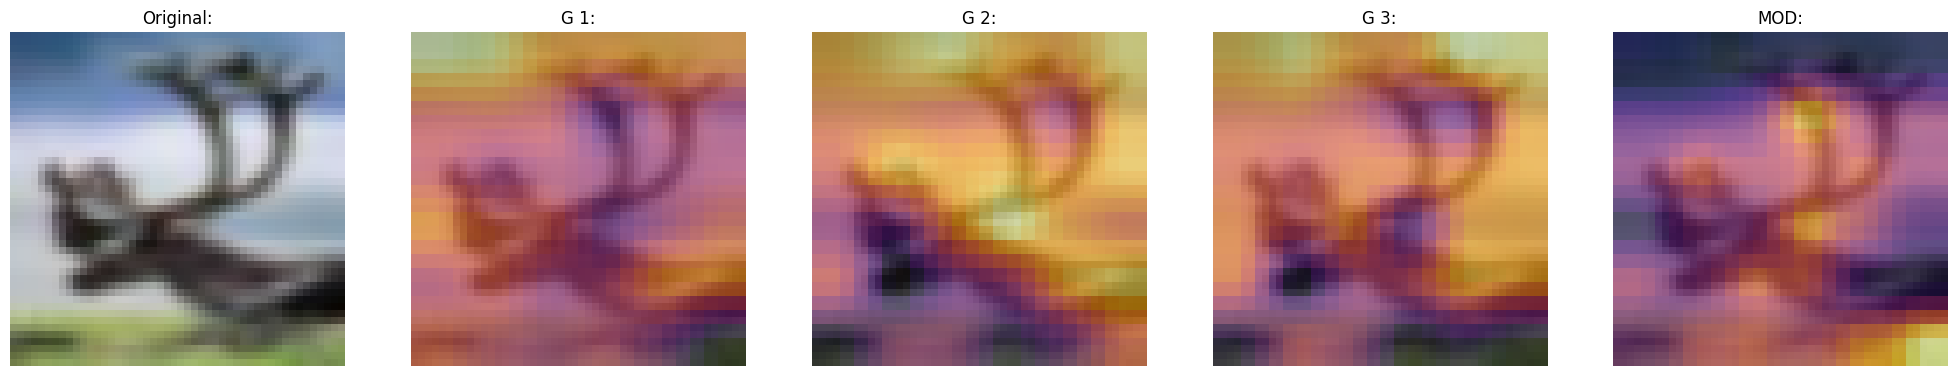

800/800 [==============================] - 99s 105ms/step - loss: 2.1170 - accuracy: 0.2186 - val_loss: 2.0582 - val_accuracy: 0.3060
Epoch 2/25
800/800 [==============================] - 90s 113ms/step - loss: 1.6075 - accuracy: 0.4144 - val_loss: 1.4076 - val_accuracy: 0.4967
Epoch 3/25
800/800 [==============================] - 91s 114ms/step - loss: 1.2699 - accuracy: 0.5436 - val_loss: 1.1491 - val_accuracy: 0.5931
Epoch 4/25
800/800 [==============================] - 92s 115ms/step - loss: 1.0513 - accuracy: 0.6264 - val_loss: 0.9911 - val_accuracy: 0.6527
Epoch 5/25
800/800 [==============================] - 93s 116ms/step - loss: 0.8841 - accuracy: 0.6898 - val_loss: 0.9199 - val_accuracy: 0.6824
Epoch 6/25
800/800 [==============================] - 92s 115ms/step - loss: 0.7459 - accuracy: 0.7391 - val_loss: 0.7806 - val_accuracy: 0.7343
Epoch 7/25
800/800 [==============================] - 93s 116ms/step - loss: 0.6343 - accuracy: 0.7772 - val_loss: 0.7761 - val_accuracy: 0.7

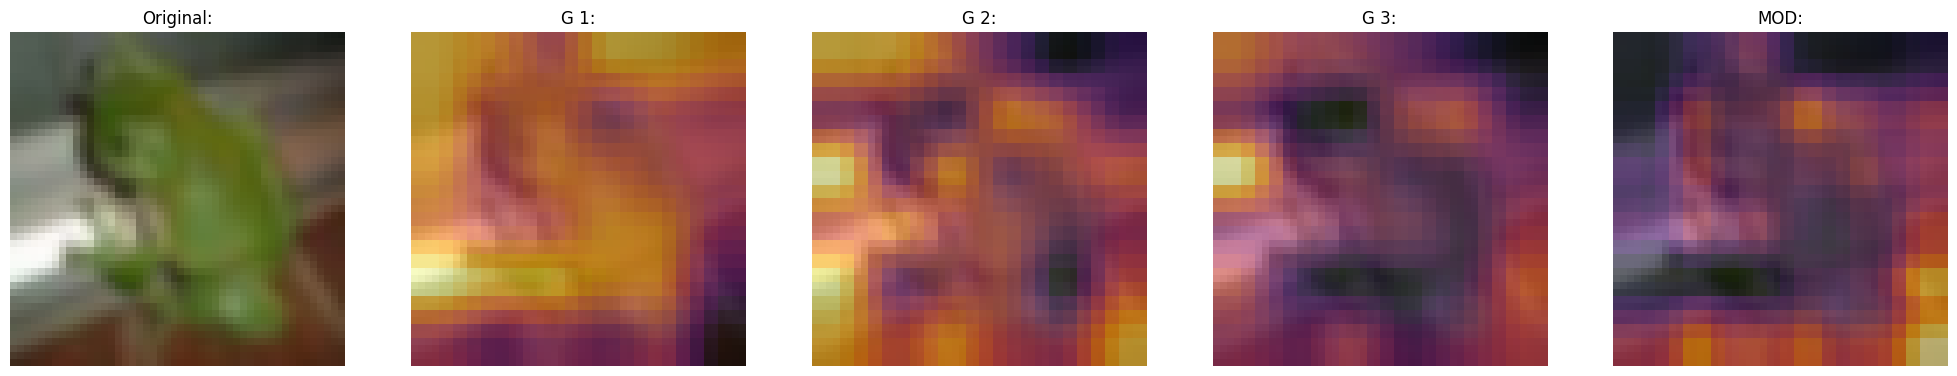

800/800 [==============================] - 93s 116ms/step - loss: 0.3101 - accuracy: 0.8938 - val_loss: 0.6914 - val_accuracy: 0.7906
Epoch 12/25
800/800 [==============================] - 93s 116ms/step - loss: 0.2543 - accuracy: 0.9128 - val_loss: 0.7116 - val_accuracy: 0.7895
Epoch 13/25
800/800 [==============================] - 93s 116ms/step - loss: 0.2062 - accuracy: 0.9289 - val_loss: 0.7128 - val_accuracy: 0.8007
Epoch 14/25
800/800 [==============================] - 93s 116ms/step - loss: 0.1581 - accuracy: 0.9467 - val_loss: 0.7302 - val_accuracy: 0.8020
Epoch 15/25
800/800 [==============================] - 93s 116ms/step - loss: 0.1288 - accuracy: 0.9570 - val_loss: 0.7538 - val_accuracy: 0.8022
Epoch 16/25
800/800 [==============================] - 93s 116ms/step - loss: 0.0984 - accuracy: 0.9674 - val_loss: 0.7777 - val_accuracy: 0.8068
Epoch 17/25
800/800 [==============================] - 93s 116ms/step - loss: 0.0782 - accuracy: 0.9746 - val_loss: 0.7649 - val_accurac

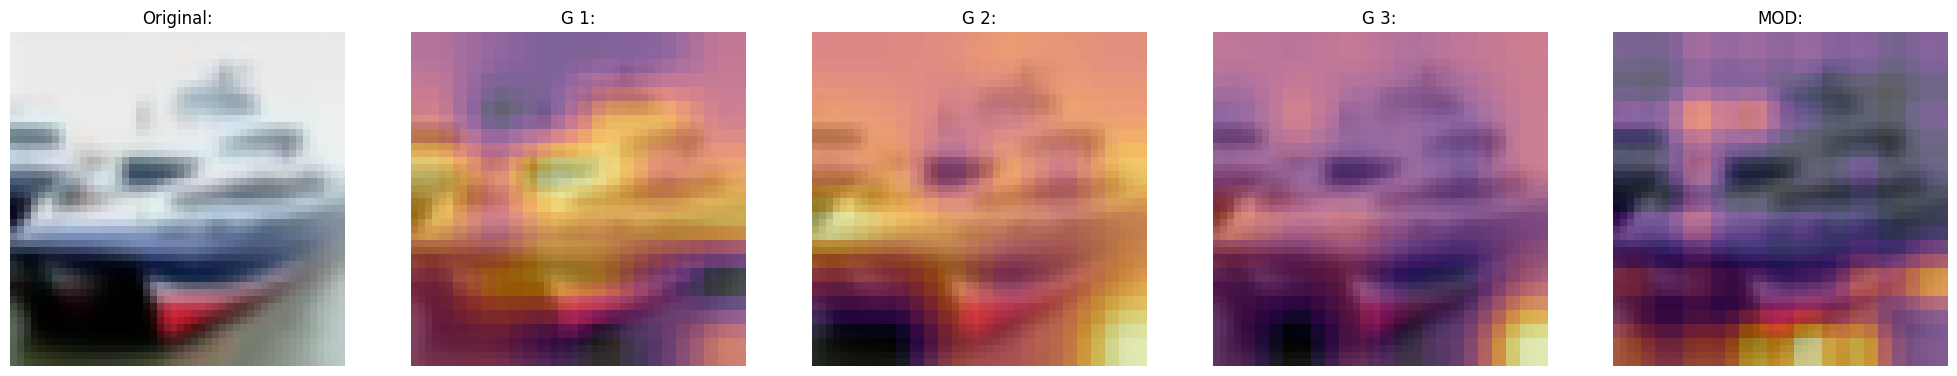

800/800 [==============================] - 94s 117ms/step - loss: 0.0318 - accuracy: 0.9901 - val_loss: 0.8072 - val_accuracy: 0.8180
Epoch 22/25
800/800 [==============================] - 94s 117ms/step - loss: 0.0252 - accuracy: 0.9926 - val_loss: 0.7967 - val_accuracy: 0.8238
Epoch 23/25
800/800 [==============================] - 93s 117ms/step - loss: 0.0223 - accuracy: 0.9936 - val_loss: 0.8018 - val_accuracy: 0.8269
Epoch 24/25
800/800 [==============================] - 93s 117ms/step - loss: 0.0213 - accuracy: 0.9937 - val_loss: 0.8054 - val_accuracy: 0.8244
Epoch 25/25
800/800 [==============================] - 94s 117ms/step - loss: 0.0203 - accuracy: 0.9943 - val_loss: 0.8053 - val_accuracy: 0.8250


In [15]:
focal_mod_net = FocalModulationNetwork()
optimizer = AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

# Compile and train the model.
focal_mod_net.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
history = focal_mod_net.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[TrainMonitor(epoch_interval=10)],
)

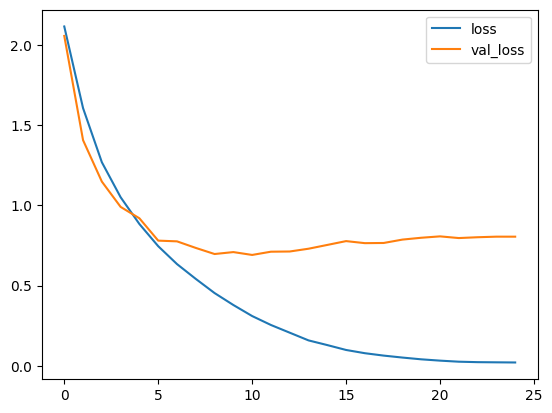

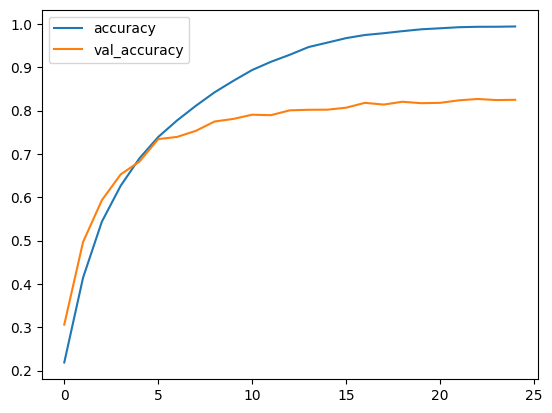

In [16]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.legend()
plt.show()

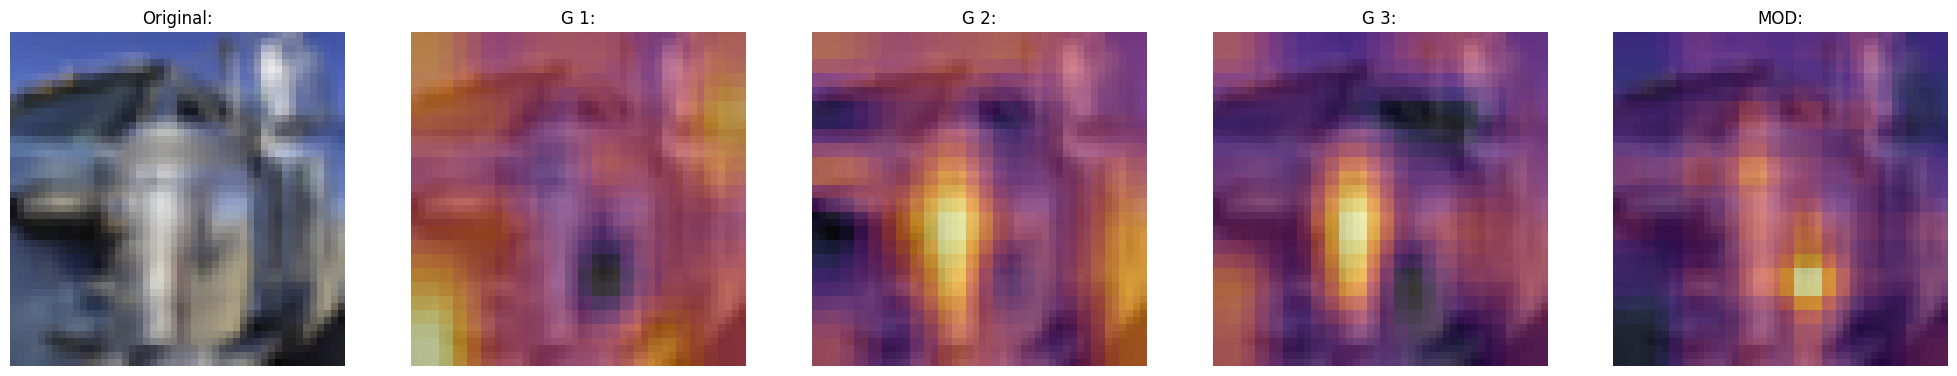

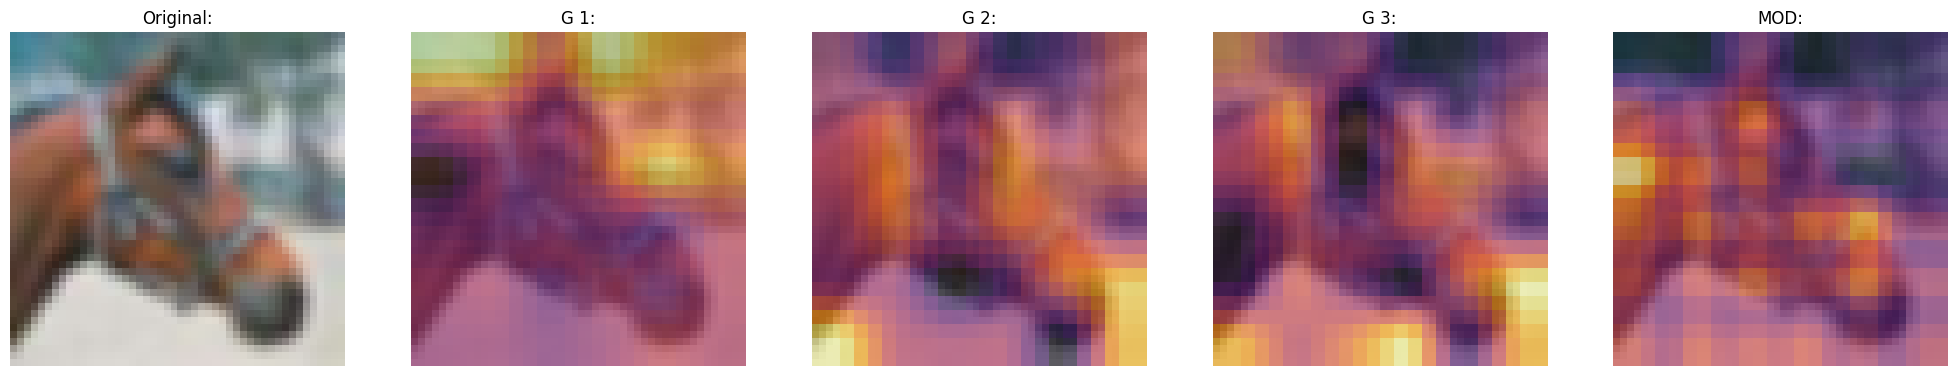

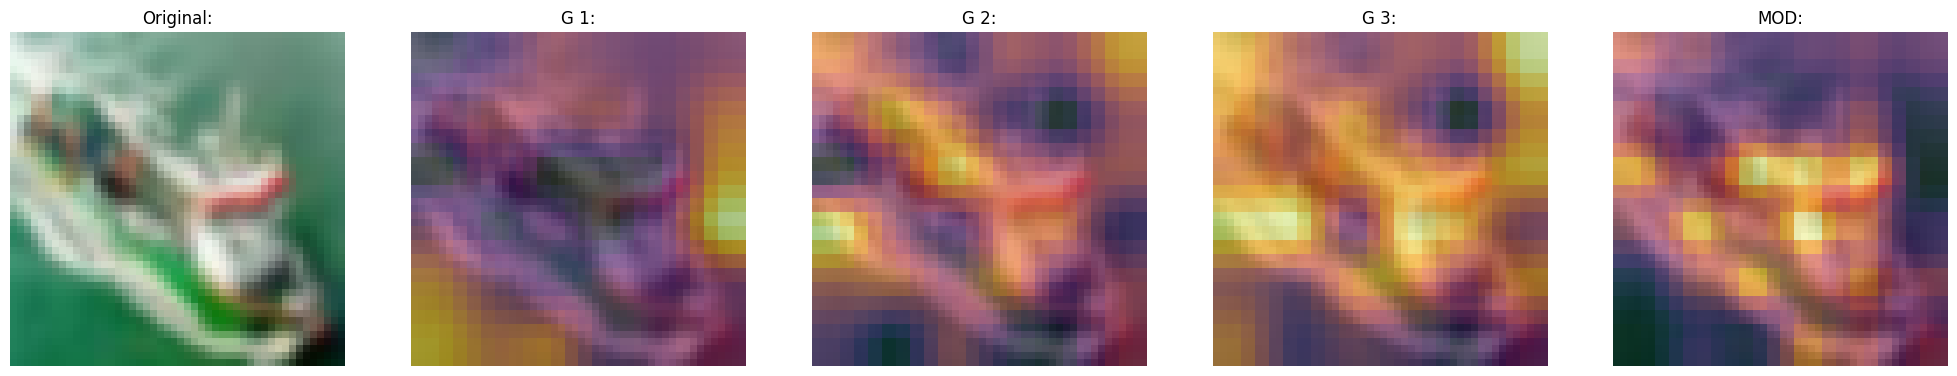

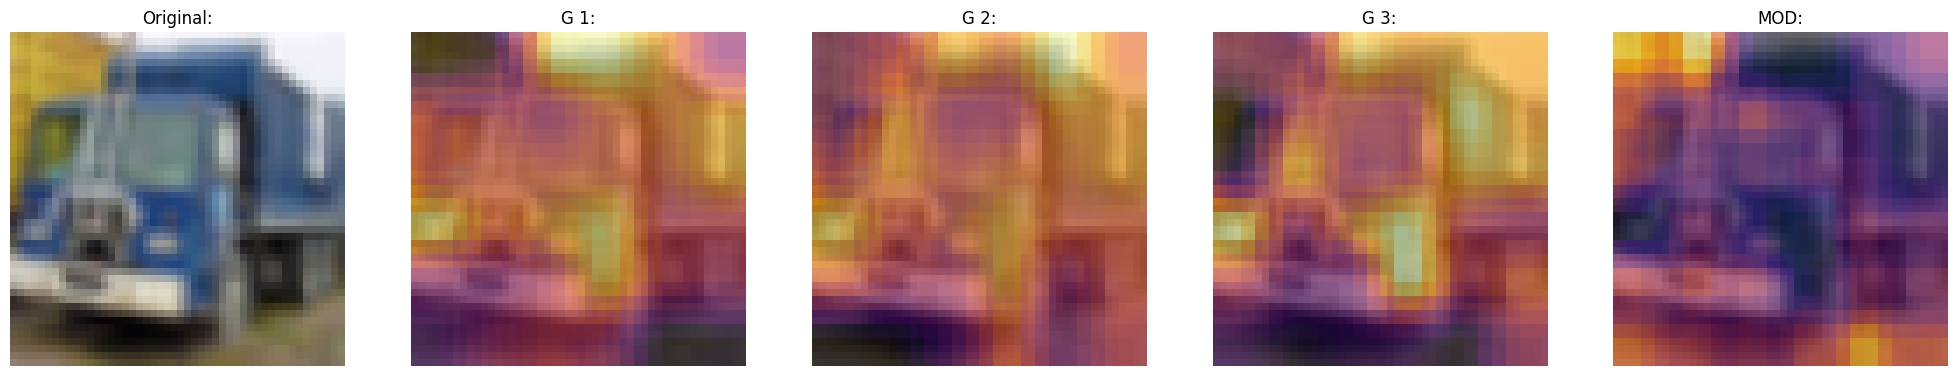

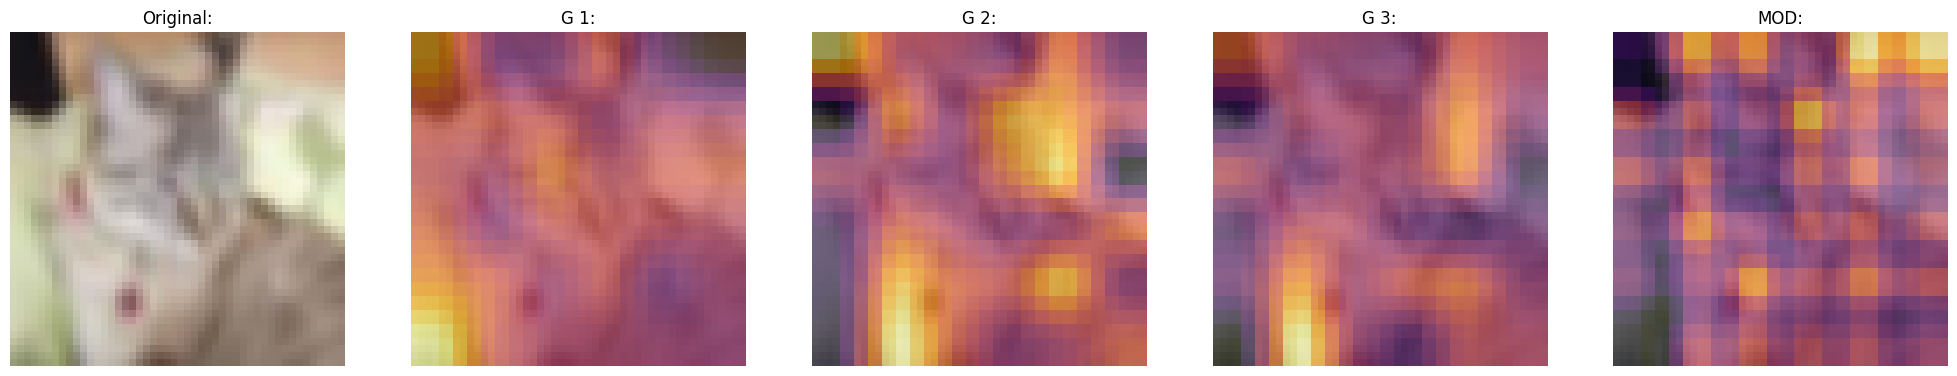

In [17]:
test_images, test_labels = next(iter(test_ds))
_ = focal_mod_net(test_images)

# Take the mid layer for visualization
gates = focal_mod_net.basic_layers[1].blocks[-1].modulation.gates
gates = upsampler(gates)
modulator = focal_mod_net.basic_layers[1].blocks[-1].modulation.modulator
modulator = upsampler(modulator)

# Plot the test images with the gates and modulator overlayed.
for row in range(5):
    display_grid(
        test_images=test_images,
        gates=gates,
        modulator=modulator,
    )